In [1]:
from IPython.display import HTML
from toggle_input import toggle_input
HTML(toggle_input)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%pylab inline
rcParams['font.size'] = 14

Populating the interactive namespace from numpy and matplotlib


# End-to-end Processing Example

The following is an example of how to put all of the pieces of RiverObs together to process a reach for SWOT simulated data. The data used are the output of the SWOT hydrology simulator, but should not necessarily be considered as being fully representative of the SWOT performance. This is just a tutorial example that show how all of the components of RiverObs can be put together to produce kml and shapefile outputs.

This example also shows how the RiverObs objects can be interrogated to produce diagnostic plots.

In [4]:
from os.path import join
from SWOTRiver import SWOTRiverEstimator
from RiverObs import RiverReachWriter

/Users/erodrigu/anaconda/envs/RiverObs/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Input Cells

The following cells are the only ones that one should have to modify for each run.

### The first cell has the data location

In [5]:
# These are the locations of the reach data and the width data base (if desired)

# This is the width database (if desired)

width_db_file = None #'../../../RiverObsTestData/GRWDL/nAmerica_GRWDL.h5' 

# This is the path to the reach files (not including the .shp suffix)

shape_file_root = '../../../RiverObsTestData/River_Prior_Database/ADT_priordatabase_reaches_polylines/NA_reaches_data_discharge_depth_chn_grdc_revised_GCS'

# This is the location of the simulated water file

l2_file = '../../../RiverObsTestData/L2/L2v1/swot_heights_ohio_example_v1.Multilook_L2PIXC.nc'

# This is the location of the output data

fout_reach = './ohioTest/swot_heights_ohio_example_v1_L2PIXC.NLoc.CClass_reach' 
fout_node = './ohioTest/swot_heights_ohio_example_v1_L2PIXC.NLoc.CClass_node' 
fout_index = './ohioTest/swot_heights_ohio_cycle_example_v1_L2PIXC.NLoc.CClass_index.nc'


### The second cell has processing options

In [6]:
# The bounding box tells what region is of interest. 
# It is sometimes required because the simulator sometimes has anomalous
# latitudes and longitudes. If this is not the case, it can be set to None.
# It does not have to be very accurate, just good enough to exclude location anomalies.
# It will be updated to the true bounding box by the program.

lonmin =  -83 
latmin =  38
lonmax =  -82
latmax =  39
bounding_box = lonmin,latmin,lonmax,latmax

# The second set of inputs have to do with what data are extracted from the
# water file.

# 'medium' or 'welldone' indicate different levels of averaging in the lines below.
# either 'latitude_medium' or 'latitude_welldone' for height files, or 'latitude' for GDEM.
lat_kwd = 'latitude_medium' 
# either 'longitude_medium' or 'longitude_welldone' for height files, or 'longitude' for GDEM.
lon_kwd = 'longitude_medium' 
# either 'classification' (estimated classification) or 'landtype' for GDEM truth
class_kwd = 'classification'
# either 'height_medium' or 'height_welldone' (estimated height) or 'elevation' (GDEM)
height_kwd = 'height_medium'

# The third set of inputs have to do with how to use the classification
# to estimate river width

# The list of classes to consider for potential inundation.
# The truth classes are [1], if no_layover_classification' is used.
# If estimated classification is used, the choice depends on whether
# use_fractional_inundation is set.
# If it is not set, either [3,4] or [4] should be used.
# If it is set, [2,3,4,5] or [3,4,5] should be used.
class_list = [2,3,4,5]

# If the L2 water file has been updated to contain the fractional
# inundation, this is the name of the variable. If it has not been
# updated or you do not wish to use it, set this to None
fractional_inundation_kwd = 'continuous_classification'

# This corresponds to the clases set above. 
# If True, use fractional inundation estimate to get the inundated area for this class.
# If False, assume that this class is fully flooded.
use_fractional_inundation=[True, True, False, False]

# This corresponds to the clases set above.
# if true, assume this class if water for feature segmentation purposes
use_segmentation=[False, True, True, True]

# This corresponds to the clases set above.
# if true, assume this class is good for estimating heights
use_heights=[False, False, True, False]

# This is the minimum number of measurements that the data set must have.
min_points=100

# The fourth set of inputs have to do with the reaches and width data base.

# The clip_buffer is a buffer (in degrees) that is drawn around the data
# bounding box so that the full reach is included and is not broken if
# the river. 0.01 ~ 1km
clip_buffer=0.02
                     
# The fifth set of options has to do with how the data are sampled and 
# quantities are estimated

# This option is only possible if you have an a priori estimate
# of width for each width point. It will load that width into
# the centerline for comparison with the estimated data.
use_width_db =  False #True

# This option determines the separation between centerline nodes.
# If set to None, the the spacing in the input reach is used.
# The units are meters. The default is to use the input reach spacing.
ds = 300.

# The next set of options are required if one desires to refine 
# the centerline if it does not align well with the data.
# If you do not know what these are, don't change them.
refine_centerline=False # Set to True if you want to refine the centerline.
smooth=1.e-2
alpha=1.
max_iter=1
# This is how far from the centerline points are accepted
scalar_max_width=600.

# This variable states how many valid data points are required before
# a node can be consired to have a sufficient number of observations.
minobs = 10

# Set this if there seem to be issues with the first/last nodes.
# This can happen sometimes in the near range.
trim_ends = True

# These are the fitting algorithms desired for mean height and slope estimation.
# More than one type of fit can be requested.
# 'OLS': ordinary least square
# 'WLS': weighted least squares
# 'RLM': Robust Linear Model
fit_types=['OLS','WLS','RLM']

# These are the minimum number of points required for a slope fit
min_fit_points = 3

# These are options useful for interctively playing with the data, but need not
# be set for batch processing.
verbose = False # Output progress to stdout
store_obs=True  # Keep the river observations for inspection
store_reaches=True # Keep the river reaches for inspection
store_fits=True # Keep the fit results for inspection


## Run the code

The following cells contain the same code as the command line program. 
It is run interactively to allow different run choices to be run interactively.

In [7]:
# Read the data and estimate the flooded area.

river_estimator = SWOTRiverEstimator(l2_file,
                                     bounding_box=bounding_box,
                                     lat_kwd=lat_kwd, 
                                     lon_kwd=lon_kwd,
                                     class_kwd=class_kwd,
                                     height_kwd=height_kwd,
                                     class_list=class_list,
                                     fractional_inundation_kwd=fractional_inundation_kwd,
                                     use_fractional_inundation=use_fractional_inundation,
                                     min_points=min_points,
                                     verbose=verbose,store_obs=store_obs,
                                     store_reaches=store_reaches,
                                     store_fits=store_fits)

# Load the reaches and width data base

river_estimator.get_reaches(shape_file_root, clip_buffer=0.1)
if width_db_file is not None:
    river_estimator.get_width_db(width_db_file)

# Process all of the reaches

river_reach_collection = river_estimator.process_reaches(scalar_max_width=scalar_max_width,
                minobs=minobs,min_fit_points=min_fit_points,
                fit_types=fit_types,
                use_width_db = use_width_db,
                ds=ds,
                refine_centerline=refine_centerline,
                smooth=smooth,alpha=alpha,max_iter=max_iter)



got pixel area from l2 file
DOMINANT LABEL in reach: 1
num nodes in reach 4
numNodes,k: 4 3
DOMINANT LABEL in reach: 1
num nodes in reach 13
numNodes,k: 13 3
DOMINANT LABEL in reach: 2
num nodes in reach 34
numNodes,k: 34 3
DOMINANT LABEL in reach: 2
num nodes in reach 34
numNodes,k: 34 3
DOMINANT LABEL in reach: 1
num nodes in reach 34
numNodes,k: 34 3
DOMINANT LABEL in reach: 2
num nodes in reach 34
numNodes,k: 34 3
DOMINANT LABEL in reach: 1
num nodes in reach 10
numNodes,k: 10 3
DOMINANT LABEL in reach: 2
num nodes in reach 14
numNodes,k: 14 3


In [8]:
# Initialize the output writer
#print river_reach_collection
reach_output_variables = list(river_reach_collection[0].metadata.keys())
# Brent williams May 2017: added extra fields
node_output_variables = ['lat','lon','x','y','nobs','s',
                             'w_ptp','w_std','w_area','w_db','area',
                             'h_n_ave','h_n_std','h_a_ave','h_a_std',
                             'nobs_h','x_prior','y_prior','node_indx','reach_indx']

writer = RiverReachWriter(river_reach_collection,
                      node_output_variables,
                      reach_output_variables)

# Write shapefiles

driver = 'ESRI Shapefile'
writer.write_nodes_ogr(fout_node,driver=driver)
writer.write_reaches_ogr(fout_reach,driver=driver)

# Write KML files

driver = 'KML'
writer.write_nodes_ogr(fout_node+'.kml',driver=driver)
writer.write_reaches_ogr(fout_reach+'.kml',driver=driver)

## Plot results for one reach

In [9]:
# This cell extracts from the results all of the appropriate data to plot

# This is the each index to use

reach_id = 10
reach_idx = river_estimator.reaches.reach_idx[reach_id]

# Extract the reach to visualize

reach = river_estimator.reaches[reach_id]
reach_idx = reach.reach_index
river_reach = river_estimator.river_reach_collection[reach_id]
river_obs = river_estimator.river_obs_collection[reach_idx]

# Extract the fit results

nresults = river_estimator.fit_collection[reach_id,'noise']

# Extract the data by class and inside the reach
lonmin = reach.lon.min()
lonmax = reach.lon.max()
latmin = reach.lat.min()
latmax = reach.lat.max()
index = ((river_estimator.lat >= latmin-0.01) &
         (river_estimator.lon >= lonmin-0.01) &
         (river_estimator.lat <= latmax+0.01) &
         (river_estimator.lon <= lonmax+0.01) 
         )
X = {}
Y = {}
c = {2:'brown',3:'aqua',4:'blue'}
name = {2:'land-edge',3:'water-edge',4:'water'}
for k in river_estimator.class_list:
    kindex = river_estimator.klass[index] == k
    X[k] = river_estimator.x[index][kindex]/1.e3
    Y[k] = river_estimator.y[index][kindex]/1.e3

s = river_reach.s
x = s - s.mean()

# Noise fits WLS

wls_n_h_mean = nresults['WLS'].params[1]
wls_n_slp = nresults['WLS'].params[0]
n_hfit_wls = wls_n_slp*x + wls_n_h_mean 
h_n = river_reach.h_n_ave
h_n_std = river_reach.h_n_std

# Noise fits OLS

ols_n_h_mean = nresults['OLS'].params[1]
ols_n_slp = nresults['OLS'].params[0]
n_hfit_ols = ols_n_slp*x + ols_n_h_mean 

### Plot input data for the resired reach

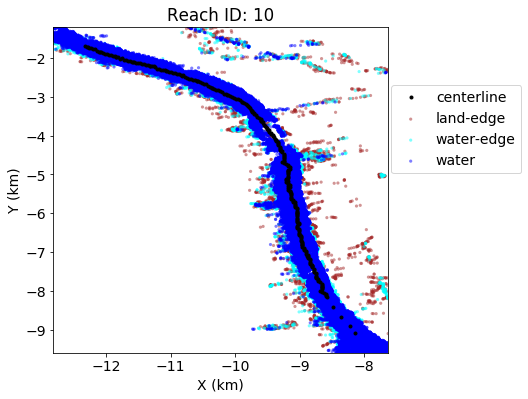

In [10]:
# Plot the reach (in projected Cartesian coordinates)

figsize(6,6)
plot(reach.x/1.e3,reach.y/1.e3,'.k',linewidth=2,label='centerline')
for k in river_estimator.class_list:
    try:
        scatter(X[k],Y[k],c=c[k],s=10,alpha=0.5,label=name[k],edgecolor='none')
    except:
        pass
xlabel('X (km)')
ylabel('Y (km)')
xmin = reach.x.min()/1.e3
xmax = reach.x.max()/1.e3
ymin = reach.y.min()/1.e3
ymax = reach.y.max()/1.e3
xlim(xmin-0.5,xmax+0.5)
ylim(ymin-0.5,ymax+0.5)
legend(loc=(1.01,0.55))
title('Reach ID: %d'%reach_id);

**Figure**: Input *a priori* reach (black line) with estimated classification: Open water (blue); water edge (aqua); land edge (brown). 

### Plot the centerline and the mean node coordinates

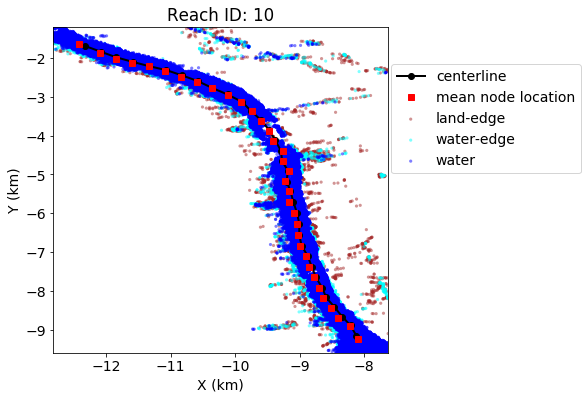

In [11]:
# Plot the reach (in projected Cartesian coordinates)

centerline = river_obs.centerline

figsize(6,6)
plot(centerline.x/1.e3,centerline.y/1.e3,'-ok',linewidth=2,label='centerline')
plot(river_reach.x/1.e3,river_reach.y/1.e3,'sr',linewidth=2,label='mean node location')
for k in river_estimator.class_list:
    try:
        scatter(X[k],Y[k],c=c[k],s=10,alpha=0.5,label=name[k],edgecolor='none')
    except:
        pass
xlabel('X (km)')
ylabel('Y (km)')
xmin = reach.x.min()/1.e3
xmax = reach.x.max()/1.e3
ymin = reach.y.min()/1.e3
ymax = reach.y.max()/1.e3
xlim(xmin-0.5,xmax+0.5)
ylim(ymin-0.5,ymax+0.5)
legend(loc=(1.01,0.55))
title('Reach ID: %d'%reach_id);

### Compare the width estimates

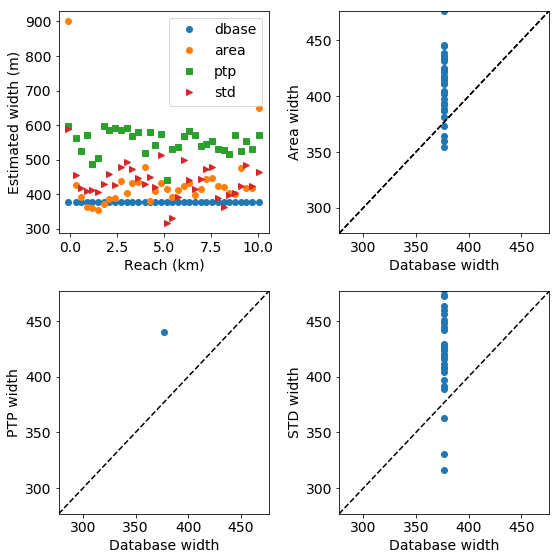

In [12]:
w = river_reach.w_db
width_std = river_reach.w_std
width_ptp = river_reach.w_ptp
width_area = river_reach.w_area
figsize(8,8)
subplot(2,2,1)
plot(river_reach.s/1.e3,river_reach.w_db,'o',label='dbase')
plot(river_reach.s/1.e3,river_reach.w_area,'o',label='area')
plot(river_reach.s/1.e3,river_reach.w_ptp,'s',label='ptp')
plot(river_reach.s/1.e3,river_reach.w_std,'>',label='std')
xlabel('Reach (km)')
ylabel('Estimated width (m)')
legend(loc='best')
subplot(2,2,2)
plot(w,width_area,'o')
plot([w.min()-100,w.max()+100],[w.min()-100,w.max()+100],'--k')
xlim(w.min()-100,w.max()+100)
ylim(w.min()-100,w.max()+100)
plot([w.min()-100,w.max()+100],[w.min()-100,w.max()+100],'--k')
xlabel('Database width')
ylabel('Area width')
subplot(2,2,3)
plot(w,width_ptp,'o')
plot([w.min()-100,w.max()+100],[w.min()-100,w.max()+100],'--k')
xlim(w.min()-100,w.max()+100)
ylim(w.min()-100,w.max()+100)
xlabel('Database width')
ylabel('PTP width')
subplot(2,2,4)
plot(w,width_std,'o')
plot([w.min()-100,w.max()+100],[w.min()-100,w.max()+100],'--k')
xlim(w.min()-100,w.max()+100)
ylim(w.min()-100,w.max()+100)
xlabel('Database width')
ylabel('STD width')
tight_layout();

### Plot the fit results

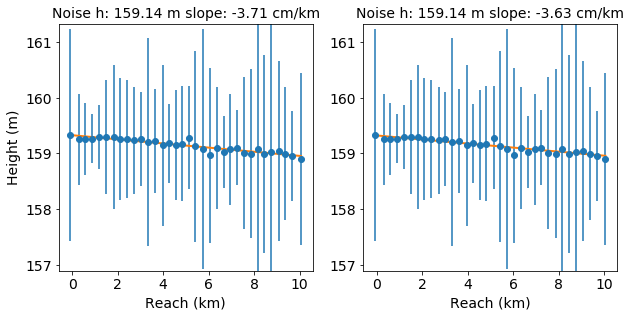

In [13]:
ymin = h_n.min() - 2
ymax = h_n.max() + 2
figsize(10,10)
subplot(2,2,1)
errorbar(s/1.e3,h_n,yerr=h_n_std,fmt='o')
plot(s/1.e3,n_hfit_ols,linewidth=2)
ylim(ymin,ymax)
title('Noise h: %.2f m slope: %.2f cm/km'%(ols_n_h_mean,ols_n_slp*1.e5),fontsize=14)
xlabel('Reach (km)')
ylabel('Height (m)')

subplot(2,2,2)
errorbar(s/1.e3,h_n,yerr=h_n_std,fmt='o')
plot(s/1.e3,n_hfit_wls,linewidth=2)
ylim(ymin,ymax)
title('Noise h: %.2f m slope: %.2f cm/km'%(wls_n_h_mean,wls_n_slp*1.e5),fontsize=14)
xlabel('Reach (km)')